In [24]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

In [25]:
from IPython import display
import io
import PIL
from matplotlib import pyplot as plt
import math

In [26]:
import time

In [27]:
import matplotlib
matplotlib.rcParams.update({'font.size': 20})
import torch
from torch import nn
from torch.autograd import Variable
from torch.nn import Parameter

import numpy as np

In [28]:
torch.manual_seed(2)

In [29]:
from Stupid_digits import stupid_digits_dataset
from Stupid_digits import get_digit

In [30]:
X,y = stupid_digits_dataset()

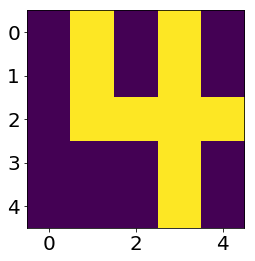

In [31]:
plt.imshow(get_digit(4).reshape(5,5))
plt.show()

In [32]:
def get_layer_info(layer):
    layer_str = str(layer)
    type_name = layer_str[:layer_str.find('(')].strip()
    return type_name


In [43]:
class LIF(nn.Module):
    # dv/dt = (I-v)/tau_v
    # dI/dt = -I/tau_I
    def __init__(self, in_neurons=1, out_neurons=1, tau_v = 20, tau_I = 15, tau_mean = 100, I_teacher_amplitude=0, threshold = 1, name='LIF', init_type='eye'):
        super(LIF, self).__init__()
        
        # layer parameters
        self.in_neurons = in_neurons
        self.out_neurons = out_neurons
        self.name = name
        self.weight = torch.zeros(self.in_neurons, self.out_neurons)
        self.init_type = init_type
        self.init_weights()
        
        #print(('Creating LIF neuron group {}, -> {}, init {}').format(self.in_neurons, self.out_neurons, self.init_type))
        # init neuron model parameters
        self.tau_v = tau_v
        self.tau_I = tau_I
        self.tau_mean = tau_mean
        self.v = torch.zeros(self.out_neurons)
        self.I = torch.zeros(self.out_neurons)
        self.I_inp = torch.zeros(self.out_neurons)
        self.I_neg = torch.zeros(self.out_neurons)
        self.I_teacher = torch.zeros(self.out_neurons)
        self.I_teacher_amplitude = I_teacher_amplitude
        self.instant_rate = torch.zeros(self.out_neurons)
        self.mean_rate = torch.zeros(self.out_neurons)
        self.threshold = torch.ones(self.out_neurons) * threshold
        self.c_inp = 1
        self.c_neg = 2
        
        self.refractoriness_state = torch.IntTensor(out_neurons).fill_(0)
        
        # monitors init
        self.monitor = Monitor(['v','I_inp','I_neg','I','threshold','instant_rate','mean_rate','weight'])
        self.monitor([self.v, self.I_inp, self.I_neg, self.I, self.threshold, self.instant_rate, self.mean_rate, self.weight])
        
    def init_weights(self):
        if self.init_type=='eye':
            self.weight = torch.eye(self.in_neurons)
        elif self.init_type=='randn':
            self.weight.normal_(0, math.sqrt(2. / self.out_neurons))
            self.weight*=0.5
            self.weight+= 0.5
        elif self.init_type=='ones':
            self.weight = torch.ones(self.weight.size())
        elif self.init_type=='cheat':
            self.weight = torch.t(torch.cat([torch.from_numpy(get_digit(i)).unsqueeze(0) for i in range(10)], dim=0)).float()
        else:
            raise Exception('Wrong init_type name: ' + self.init_type)
        print(self.weight)
            
    def update_state(self, weighted_input):
        self.I_inp -= self.I_inp/self.tau_I
        self.I_neg -= self.I_neg/self.tau_I
        self.I_inp += weighted_input
        self.I = self.I_inp * self.c_inp + self.I_teacher + self.I_neg * self.c_neg
        self.v += torch.addcmul(torch.zeros(self.v.size()), (self.I-self.v)/self.tau_v, (1-self.refractoriness_state).float())
        self.v = torch.clamp(self.v,0,100)
        
        #self.instant_rate += -self.instant_rate/self.tau_I
        #self.mean_rate += -self.mean_rate/self.tau_mean
        
    def refractoriness_check(self):
        return self.refractoriness_state
    
    def get_spikes(self):
        # get binary spike events
        self.spikes = self.v >= self.threshold
        
        # set v to zero to those neurons that spiked
        self.v = torch.addcmul(torch.zeros(self.v.size()), self.v,(1-self.spikes).float())
        
        # set those neurons that spiked into the refractoriness state
        self.refractoriness_state = self.spikes
        
        # update those neurons that spiked instant and mean firing rate
        self.instant_rate += (self.spikes.float() - self.instant_rate)/self.tau_I
        self.mean_rate += (self.spikes.float() - self.mean_rate)/self.tau_mean
        
        return self.spikes
        
    def forward(self, x, target=None):
        self.I_teacher[target] = self.I_teacher_amplitude
        weighted_input = x.float().matmul(self.weight)
        self.update_state(weighted_input)
        x = self.get_spikes()
        self.monitor([self.v, self.I_inp, self.I_neg, self.I, self.threshold, self.instant_rate, self.mean_rate, self.weight])
        return x
    
class Monitor(nn.Module):
    def __init__(self, var_list, record_time=300):
        super(Monitor, self).__init__()
        self.record_time = record_time
        self.monitor_dict = {}
        self.var_list = var_list
        #print("Creating Monitor")
        for var in var_list:
            self.monitor_dict[var] = []
    
    def forward(self, x):
        for i,value in enumerate(x):
            self.monitor_dict[self.var_list[i]].append(value.clone().cpu().numpy().tolist())
            if len(self.monitor_dict[self.var_list[i]]) > self.record_time:
                self.monitor_dict[self.var_list[i]] = self.monitor_dict[self.var_list[i]][1:]
    
        
            

In [44]:
class ConnectionBCM(nn.Module):
    # dw/dt = lr * instant_rate_post * (instant_rate_post - mean_rate_post) * delta_function(t - t_spike_pre) - w/decay_time
    def __init__(self, pre_layer=None, post_layer=None, lr=0.1, decay_time=10000):
        super(ConnectionBCM, self).__init__()
        
        self.pre_layer = pre_layer
        self.post_layer = post_layer
        self.lr = lr
        self.decay_time = decay_time
        
        pre_type_name = get_layer_info(pre_layer)
        post_type_name = get_layer_info(post_layer)
        
        if pre_type_name not in ['LIF']: raise Exception('Wrong pre_layer type: ' + pre_type_name)
        if post_type_name not in ['LIF']: raise Exception('Wrong post_layer type: ' + post_type_name)
            
    def forward(self, x):
        instant_rate_post_t_spike_pre = torch.addcmul(torch.zeros(self.post_layer.instant_rate.size()), self.post_layer.instant_rate.expand_as(self.post_layer.weight), torch.t(x.float().expand_as(torch.t(self.post_layer.weight))))
        self.post_layer.weight += torch.addcmul(-self.post_layer.weight/self.decay_time, self.lr*(self.post_layer.instant_rate - self.post_layer.mean_rate), instant_rate_post_t_spike_pre)
        self.post_layer.weight = torch.clamp(self.post_layer.weight,0,1)
        #print('a_post at pre spike', instant_rate_post_t_spike_pre)
        #print('dw',self.post_layer.weight)
        return x
        
class ConnectionInhibition(nn.Module):
    # dw/dt = 0
    # w_ij = -1 if i!=j else 0
    def __init__(self, pre_layer=None, post_layer=None):
        super(ConnectionInhibition, self).__init__()
        
        self.pre_layer = pre_layer
        self.post_layer = post_layer
        
        pre_type_name = get_layer_info(pre_layer)
        post_type_name = get_layer_info(post_layer)
        
        if pre_type_name not in ['LIF']: raise Exception('Wrong pre_layer type: ' + pre_type_name)
        if post_type_name not in ['LIF']: raise Exception('Wrong post_layer type: ' + post_type_name)
            
        self.weight = torch.ones((self.pre_layer.out_neurons, self.post_layer.out_neurons))*(-1) + torch.eye(self.pre_layer.out_neurons)
            
    def forward(self, x):
        self.post_layer.I_neg += x.float().matmul(self.weight)
        return x
            
        

In [45]:
input_layer = LIF(in_neurons=25, out_neurons=25, tau_v=4, tau_I=3, threshold=1)
input_inverse_layer = LIF(in_neurons=25, out_neurons=25, tau_v=4, tau_I=3, threshold=1)
output_layer = LIF(in_neurons=50, out_neurons=10, tau_v=4, tau_I=3, I_teacher_amplitude=5, threshold=3, init_type='cheat')



Columns 0 to 12 
    1     0     0     0     0     0     0     0     0     0     0     0     0
    0     1     0     0     0     0     0     0     0     0     0     0     0
    0     0     1     0     0     0     0     0     0     0     0     0     0
    0     0     0     1     0     0     0     0     0     0     0     0     0
    0     0     0     0     1     0     0     0     0     0     0     0     0
    0     0     0     0     0     1     0     0     0     0     0     0     0
    0     0     0     0     0     0     1     0     0     0     0     0     0
    0     0     0     0     0     0     0     1     0     0     0     0     0
    0     0     0     0     0     0     0     0     1     0     0     0     0
    0     0     0     0     0     0     0     0     0     1     0     0     0
    0     0     0     0     0     0     0     0     0     0     1     0     0
    0     0     0     0     0     0     0     0     0     0     0     1     0
    0     0     0     0     0     0     0    

In [46]:
BCM_rule = ConnectionBCM(input_layer, output_layer)
BCM_inverse_rule = ConnectionBCM(input_inverse_layer, output_layer)
inhibition_rule = ConnectionInhibition(output_layer, output_layer)

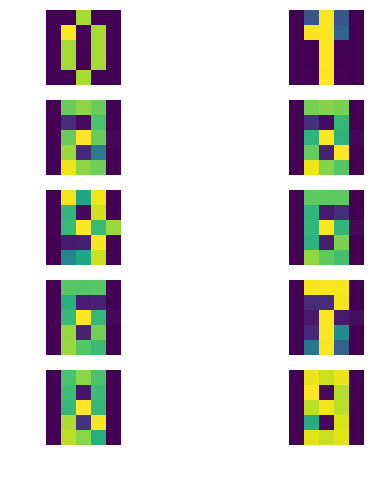

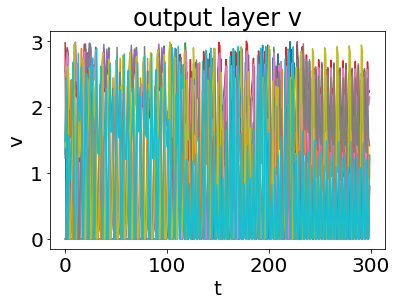

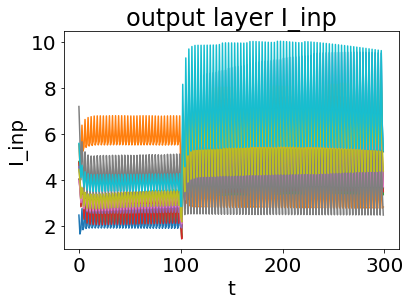

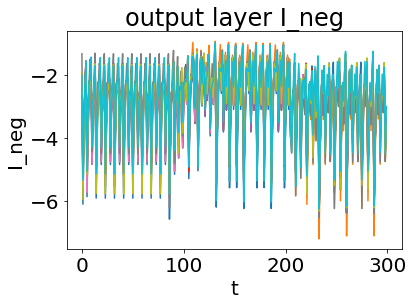

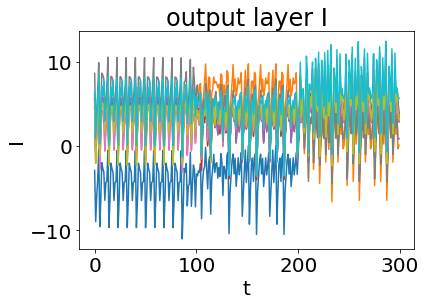

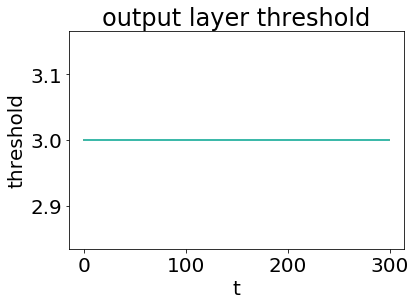

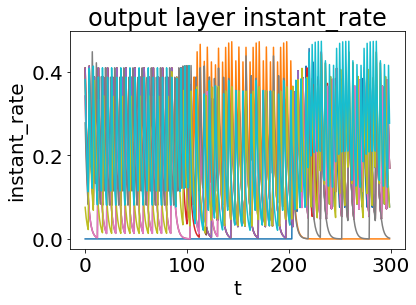

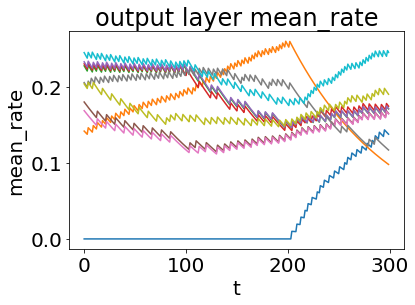

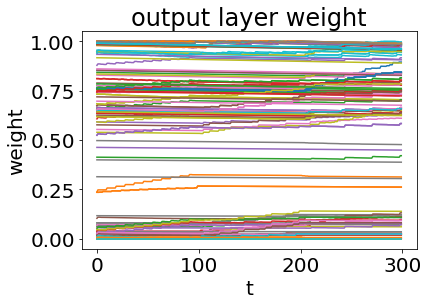

/media/d.nekhaev/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


KeyboardInterrupt: 

In [47]:
for i in np.arange(10000):
    input = torch.from_numpy(X[i // 100])
    target = y[i // 100]
    start = time.time()
    x1 = input_layer(input)
    x2 = input_inverse_layer(1-input)
    x1 = BCM_rule(x1)
    x2 = BCM_rule(x2)
    x = torch.cat([x1,x2])
    x = output_layer(x, target)
    x = inhibition_rule(x)
    #print(x.sum(), target)
    end = time.time()
    if i==0:
        #weights
        fig = plt.figure(figsize=(8,8))
        for j in np.arange(output_layer.out_neurons):
            plt.subplot(5,2,j+1)
            plt.imshow(output_layer.weight.numpy()[:,j].reshape(5,5))
            plt.axis('off')
        display.display(fig, display_id = 'weights')
        
        #monitors
        for key in output_layer.monitor.monitor_dict.keys():
            fig = plt.figure('output' + key)
            plt.cla()
            plt.title('output layer ' + key)
            x = np.array(output_layer.monitor.monitor_dict[key])
            x = x.reshape(x.shape[0],-1)
            plt.plot(x)
            plt.ylabel(key)
            plt.xlabel('t')
            display.display(fig, display_id = 'output layer ' + key)
    else:
        if i%100==0:
            fig = plt.figure(figsize=(8,8))
            start = time.time()
            for j in np.arange(output_layer.out_neurons):
                plt.subplot(5,2,j+1)
                plt.imshow(output_layer.weight.numpy()[:,j].reshape(5,5))
                plt.axis('off')
            end = time.time()
            #print('mpl',end-start)
            start = time.time()
            display.update_display(fig, display_id = 'weights')
            end = time.time()
            #print('display',end-start)
                
            for key in output_layer.monitor.monitor_dict.keys():
                fig = plt.figure('output' + key)
                plt.cla()
                plt.title('output layer ' + key)
                x = np.array(output_layer.monitor.monitor_dict[key])
                x = x.reshape(x.shape[0],-1)
                plt.plot(x)
                plt.ylabel(key)
                plt.xlabel('t')
                display.update_display(fig, display_id = 'output layer ' + key)
        

In [ ]:
len(input_layer.monitor.monitor_dict['I_inp'][0])

In [ ]:
x

In [ ]:
for key in input_layer.monitor.monitor_dict.keys():
    plt.figure('input')
    plt.title('Input layer ' + key)
    x = np.array(input_layer.monitor.monitor_dict[key])
    x = x.reshape(x.shape[0],-1)
    plt.plot(x)
    plt.ylabel(key)
    plt.xlabel('t')
    plt.show()

In [ ]:
for key in output_layer.monitor.monitor_dict.keys():
    plt.figure('output')
    plt.title('Output layer ' + key)
    x = np.array(output_layer.monitor.monitor_dict[key])
    x = x.reshape(x.shape[0],-1)
    plt.plot(x)
    plt.ylabel(key)
    plt.xlabel('t')
    plt.show()

In [ ]:
b=torch.Tensor([1,0,1,0,0])
b.size()

In [ ]:
b.expand_as(torch.Tensor(20,5))

In [ ]:
BCM_rule.post_layer.weight.size()

In [ ]:
torch.t(b.expand_as(torch.Tensor(20,5)))

In [ ]:
fig= plt.figure()

In [ ]:
plt.subplot(2,2,1)
plt.imshow(np.random.random(size=(10,10)))
plt.subplot(2,2,2)
plt.imshow(np.random.random(size=(10,10)))
plt.subplot(2,2,3)
plt.imshow(np.random.random(size=(10,10)))
plt.subplot(2,2,4)
plt.imshow(np.random.random(size=(10,10)))

In [ ]:
display.display(fig)

In [ ]:
x[2]